In [1]:
from os import listdir
from os.path import isfile, join
# from Utils import Load, Write
import pandas as pd
import numpy as np
from scipy import stats
# import math
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import cm
# import plotly.plotly as py
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
from pop_calcs import *
from pop_organize import *

In [27]:
def sigma(x):
    sigma=0
    for n in range(x):
        sigma+=n
    return sigma

In [ ]:
def get_sample_with_dfs():
    print 'getting list of samples that have dfs...'
    df_file_names = [f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles", f))]
    df_file_names = [df_file for df_file in df_file_names if df_file.startswith ('sample_df_HIP')]
    samples_with_df=[s.replace("sample_df_", "") for s in df_file_names]
    print 'finished getting list of samples that have dfs'
    return df_file_names,samples_with_df

In [ ]:
def get_sample_data(sample_name, generate_dfs): 
## this function generates dfs (general, only productive and only non productive) for each sample, and save
## as pickles. alternatively, it loads these dfs from pickles. 
    
    print 'getting sample data...'
    
    if generate_dfs:
        sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
        sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']
        sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
        
        pickle.dump(sample_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name, "wb"))
        pickle.dump(sample_df_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name, "wb"))
        pickle.dump(sample_df_non_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name, "wb"))
    else:
        sample_df= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name,"rb" ))
        sample_df_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name,"rb" ))
        sample_df_non_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name,"rb" ))
    
    print 'finished getting sample data'
    return sample_df, sample_df_prod, sample_df_non_prod

## sequence comparison using Boyer-Moore and the pigenhole principle

#### Boyer-Moore preprocessing:

In [2]:
"""bm_preproc.py: Boyer-Moore preprocessing."""

__author__ = "Ben Langmead"

import unittest


def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)

    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break

    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1

    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


def n_array(s):
    """ Compile the N array (Gusfield theorem 2.2.2) from the Z array """
    return z_array(s[::-1])[::-1]


def big_l_prime_array(p, n):
    """ Compile L' array (Gusfield theorem 2.2.2) using p and N array.
        L'[i] = largest index j less than n such that N[j] = |P[i:]| """
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp


def big_l_array(p, lp):
    """ Compile L array (Gusfield theorem 2.2.2) using p and L' array.
        L[i] = largest index j less than n such that N[j] >= |P[i:]| """
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    """ Compile lp' array (Gusfield theorem 2.2.4) using N array. """
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp


def good_suffix_table(p):
    """ Return tables needed to apply good suffix rule. """
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array(n)


def good_suffix_mismatch(i, big_l_prime, small_l_prime):
    """ Given a mismatch at offset i, and given L/L' and l' arrays,
        return amount to shift as determined by good suffix rule. """
    length = len(big_l_prime)
    assert i < length
    if i == length - 1:
        return 0
    i += 1  # i points to leftmost matching position of P
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]


def good_suffix_match(small_l_prime):
    """ Given a full match of P to T, return amount to shift as
        determined by good suffix rule. """
    return len(small_l_prime) - small_l_prime[1]


def dense_bad_char_tab(p, amap):
    """ Given pattern string and list with ordered alphabet characters, create
        and return a dense bad character table.  Table is indexed by offset
        then by character. """
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab


class BoyerMoore(object):
    """ Encapsulates pattern and associated Boyer-Moore preprocessing. """

    def __init__(self, p, alphabet='ACGT'):
        # Create map from alphabet characters to integers
        self.amap = {alphabet[i]: i for i in range(len(alphabet))}
        # Make bad character rule table
        self.bad_char = dense_bad_char_tab(p, self.amap)
        # Create good suffix rule table
        _, self.big_l, self.small_l_prime = good_suffix_table(p)

    def bad_character_rule(self, i, c):
        """ Return # skips given by bad character rule at offset i """
        assert c in self.amap
        assert i < len(self.bad_char)
        ci = self.amap[c]
        return i - (self.bad_char[i][ci]-1)

    def good_suffix_rule(self, i):
        """ Given a mismatch at offset i, return amount to shift
            as determined by (weak) good suffix rule. """
        length = len(self.big_l)
        assert i < length
        if i == length - 1:
            return 0
        i += 1  # i points to leftmost matching position of P
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length - self.small_l_prime[i]

    def match_skip(self):
        """ Return amount to shift in case where P matches T """
        return len(self.small_l_prime) - self.small_l_prime[1]


class TestBoyerMoorePreproc(unittest.TestCase):

    def test_z_1(self):
        s = 'abb'
        #    -00
        z = z_array(s)
        self.assertEqual([3, 0, 0], z)

    def test_z_2(self):
        s = 'abababab'
        #    00604020
        z = z_array(s)
        self.assertEqual([8, 0, 6, 0, 4, 0, 2, 0], z)

    def test_z_3(self):
        s = 'abababab'
        #    00604020
        z = z_array(s)
        self.assertEqual([8, 0, 6, 0, 4, 0, 2, 0], z)

    def test_n_1(self):
        s = 'abb'
        #    01-
        n = n_array(s)
        self.assertEqual([0, 1, 3], n)

    def test_n_2(self):
        s = 'abracadabra'
        #    1004010100-
        n = n_array(s)
        self.assertEqual([1, 0, 0, 4, 0, 1, 0, 1, 0, 0, 11], n)

    def test_n_3(self):
        s = 'abababab'
        #    0204060-
        n = n_array(s)
        self.assertEqual([0, 2, 0, 4, 0, 6, 0, 8], n)

    def test_big_l_prime_1(self):
        s = 'abb'
        #    001
        big_l_prime = big_l_prime_array(s, n_array(s))
        self.assertEqual([0, 0, 2], big_l_prime)

    def test_big_l_prime_2(self):
        s = 'abracadabra'
        #    01234567890
        # L' 00000003007
        # L  00000003337
        big_l_prime = big_l_prime_array(s, n_array(s))
        self.assertEqual([0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 8], big_l_prime)

    def test_small_l_prime_1(self):
        s = 'abracadabra'
        # N  1004010100-
        # l'           1
        # l'        4
        # l' 44444444111
        small_l_prime = small_l_prime_array(n_array(s))
        self.assertEqual([11, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1], small_l_prime)

    def test_good_suffix_match_mismatch_1(self):
        p = 'GGTAGGT'
        big_l_prime, big_l, small_l_prime = good_suffix_table(p)
        self.assertEqual([0, 0, 0, 0, 3, 0, 0], big_l_prime)
        self.assertEqual([0, 0, 0, 0, 3, 3, 3], big_l)
        self.assertEqual([7, 3, 3, 3, 3, 0, 0], small_l_prime)
        self.assertEqual(0, good_suffix_mismatch(6, big_l_prime, small_l_prime))
        self.assertEqual(0, good_suffix_mismatch(6, big_l, small_l_prime))
        #  t:      xT
        #  p: GGTAGGT
        # L': -000300
        #  L: -000333
        self.assertEqual(7, good_suffix_mismatch(5, big_l_prime, small_l_prime))
        self.assertEqual(4, good_suffix_mismatch(5, big_l, small_l_prime))
        #  t:     xGT
        #  p: GGTAGGT
        # L': -000300
        #  L: -000333
        self.assertEqual(7, good_suffix_mismatch(4, big_l_prime, small_l_prime))
        self.assertEqual(4, good_suffix_mismatch(4, big_l, small_l_prime))
        #  t:    xGGT
        #  p: GGTAGGT
        # L': -000300
        #  L: -000333
        self.assertEqual(4, good_suffix_mismatch(3, big_l_prime, small_l_prime))
        self.assertEqual(4, good_suffix_mismatch(3, big_l, small_l_prime))
        #  t:   xAGGT
        #  p: GGTAGGT
        # L': -000300
        #  L: -000333
        self.assertEqual(4, good_suffix_mismatch(2, big_l_prime, small_l_prime))
        self.assertEqual(4, good_suffix_mismatch(2, big_l, small_l_prime))
        #  t:  xTAGGT
        #  p: GGTAGGT
        # L': -000300
        #  L: -000333
        self.assertEqual(4, good_suffix_mismatch(1, big_l_prime, small_l_prime))
        self.assertEqual(4, good_suffix_mismatch(1, big_l, small_l_prime))
        #  t: xGTAGGT
        #  p: GGTAGGT
        # L': -000300
        #  L: -000333
        self.assertEqual(4, good_suffix_mismatch(0, big_l_prime, small_l_prime))
        self.assertEqual(4, good_suffix_mismatch(0, big_l, small_l_prime))

    def test_good_suffix_table_1(self):
        s = 'abb'
        #    001
        big_l_prime, big_l, small_l_prime = good_suffix_table(s)
        self.assertEqual([0, 0, 2], big_l_prime)
        self.assertEqual([0, 0, 2], big_l)
        self.assertEqual([3, 0, 0], small_l_prime)

    def test_good_suffix_table_2(self):
        s = 'abracadabra'
        #    01234567890
        # L' 00000003007
        # L  00000003337
        # l' -4444444111
        big_l_prime, big_l, small_l_prime = good_suffix_table(s)
        self.assertEqual([0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 8], big_l_prime)
        self.assertEqual([0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 8], big_l)
        self.assertEqual([11, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1], small_l_prime)

#if __name__ == '__main__':
#    unittest.main()


#### Boyer-Moore function:

In [3]:
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching. p=pattern, t=text,
        p_bm=BoyerMoore object for p """
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        print i
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            print j
            if p[j] != t[i+j]:
                print 'mismatch'
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                print skip_bc
                skip_gs = p_bm.good_suffix_rule(j)
                print skip_gs
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            print 'match'
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences

In [4]:
## this function is used in the sequence reliability checks

def boyer_moore_with_mm(p, p_bm, t,n):
    """ Do Boyer-Moore matching. p=pattern, t=text,
        p_bm=BoyerMoore object for p, n=number of mismatches allowed"""
        
    i = 0
    
    #occurrences = []
    mm_count_list=[]
    while i < len(t) - len(p) + 1:
        mm_count=0
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            if p[j] != t[i+j]:
                mm_count+=1
                mismatched = True
                if mm_count==1:               
                    skip_bc = p_bm.bad_character_rule(j, t[i+j])
                    skip_gs = p_bm.good_suffix_rule(j)
                    shift = max(shift, skip_bc, skip_gs)
                if mm_count>n:
                    break
                            
        if not mismatched:
                #occurrences.append(i)
                skip_gs = p_bm.match_skip()
                shift = max(shift, skip_gs)
        i += shift
        mm_count_list.append(mm_count)
    min_mm=min(mm_count_list)
    return mm_count_list, min_mm

#### Approximate match definition:

In [6]:
def approximate_match (p,p_bm,t,n):

    ### currently not in use!!#######
    
    
    #n-max number of mismatches allowed, 
    
    #make the sequences reciprocal:
    #print 'start sequence matching'
    #if len(t)<len(p): ## if len(t)< len(P), the sequences of p and t are exchanged
    #    p2=p
    #    t2=t
    #    p=t2
    #    t=p2
    #    print 'replaced t and p'
    
    
    n_mis=[]
    matches=boyer_moore(p, p_bm,t) 
        for m in matches: #verify match outside the partition, taking into account
                          #the allowed number of mismatches n
            if m<start or m-start+len(p) >len(t):
                continue

            mismatches=0
            for j in range(0,start):
                if not p[j] == t[m-start+j]:
                    mismatches+=1
                    if mismatches>n:
                        break

            for j in range(end, len(p)):
                if not p[j] == t[m-start+j]:
                    mismatches+=1
                    if mismatches>n:
                        break

            n_mis.append(mismatches)
    if len(n_mis)>0:
        min_mis=min(n_mis)
    else:
        min_mis=1000
    
   
    print 'finished sequence matching'
    return min_mis

IndentationError: unexpected indent (<ipython-input-6-f959d93ed456>, line 20)

In [5]:
import os
from queue.qp import qp,fakeqp
from addloglevels import sethandlers
import logging 
from Utils import cacheOnDisk



## sending to the queue functions that check sequence reliability using the boyer-moore algorithm with mms - generalize the function:

In [18]:
sample_list=['BD64', 'BD64_281611_3','BD64_322939_1','BD64_322939_2','BD207','BD207a_05ug','BD207b_05ug',
            'BD418','BD415a_05ug','BD415b_05ug','BD418_322939_2']

In [19]:
sample_name=sample_list[2]
sample_name

'BD64_322939_1'

In [20]:
basePath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seqRel/check_seqRel_%s' %sample_name ## define the path to
if not os.path.exists(basePath):
    print 'not exist' # generate the directory of doesn't exist
    os.makedirs(basePath)

not exist


In [21]:
@cacheOnDisk(basePath=basePath, filename='%(sample_name)s_seqRel_%(min_seq)s_%(max_seq)s', force=True)
def check_seqRel(sample_name,min_seq,max_seq):
    n=3
    print 'getting sample df...'
    sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name)
    if 'count (templates)' in sample_df.columns.values:
        column='count (templates)'
    else:
        column='count (templates/reads)'
    columns_to_keep = ['nucleotide', column]
    seq_rel_df = sample_df[columns_to_keep]
    #seq_rel_df.set_index('nucleotide', inplace=True)
    print 'finished generating sample dataframes...'
    comparison_list=[]
    if max_seq>len(seq_rel_df):
        max_seq=len(seq_rel_df)
    for seq1 in range(min_seq, max_seq):
        if seq1%500==0:
            print ('count_seq1=%s' %seq1)
        p=seq_rel_df.loc[seq1,'nucleotide']
        #segment_length=round(len(p)/(n+1))
        #min_mis=1000
        #if segment_length>=2:  
        #    for i in range(n+1): # loop over partitions
        #        start=int(i*segment_length) #define start and end site for each partition
        #        end=int(min((i+1)*segment_length,len(p)))
        p_bm=BoyerMoore(p, alphabet='ACGT')
        count_seq2=0
        for seq2 in range(seq1+1,len(seq_rel_df.index)):
            #if count_seq2%50000==0:
            #    print ('count_seq2=%s' %count_seq2)
            t=seq_rel_df.loc[seq2,'nucleotide']
            mm_count_list, min_mm=boyer_moore_with_mm(p, p_bm, t,n)
            
            count_seq2=count_seq2+1
            if min_mm<=n:
                seq1_reads=seq_rel_df.loc[seq1,column]
                seq2_reads=seq_rel_df.loc[seq2,column]

                comparison_list.append({'#mm':min_mm,'#seq1':seq1,'seq1':p,'seq1 reads':seq1_reads, '#seq2':seq2,'seq2':t,'seq2 reads':seq2_reads})
    
    seq_compar_df=pd.DataFrame(comparison_list)
    return seq_compar_df




In [22]:
sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name)
sampleLength=len(sample_df)


sethandlers()
os.chdir(basePath)
## the inputs for qp are: jobname, q=machine list, *** add max_r to prevent exploding the cluster!!***
with qp('check_seqRel_job3', q=['himem7.q', 'himemint.q'], mem_def="10G", trds_def=2, deleteCSHwithnoerr=True, tryrerun=False, max_u=120) as q:
    q.startpermanentrun()
    wait_on =[]
    
##now define a loop that divide the job and send each part seperately:
## consider making a list of integer for the min/max_seq so the first jobs will be shorter than the last ones. 
    min_seq=0
    max_seq=1000
    sample_name=sample_name
    while  min_seq<sampleLength:                                     
        print min_seq
        wait_on.append(q.method(check_seqRel,kwargs={'sample_name':sample_name,'min_seq':min_seq,'max_seq':max_seq}))
            ##q.method takes the desired function with its arguments and send it to the queue.
        min_seq=min_seq+1000
        max_seq=max_seq+1000
    q.wait(wait_on)



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
wtf
2017-09-28 22:49:20,109 - qp - INFO - Sending to queue (mem 10G, threads 2): python2.7 -W ignore /home/sbenari/workspace/lib/queue/qworker.py check_seqRel_job3_087a5aa28acf48029b244755cd43ee64/0.dat;
wtf
2017-09-28 22:49:36,032 - qp - INFO - Sending to queue (mem 10G, threads 2): python2.7 -W ignore /home/sbenari/workspace/lib/queue/qworker.py check_seqRel_job3_087a5aa28acf48029b244755cd43ee64/1.dat;
wtf
2017-09-28 22:49:36,397 - qp - INFO - Sending to queue (mem 10G, threads 2): python2.7 -W ignore /home/sbenari/workspace/lib/queue/qworker.py check_seqRel_job3_087a5aa28acf48029b244755cd43ee64/2.dat;
wtf
2017-09-28 22:49:36,484 - qp - INFO - Sending to queue (mem 10G, threads 2): python2.7 -W ignore /home/sbenari/workspace/lib/queue/qworker.py check_seqRel_job3_087a5aa28acf48029b244755cd43ee64/3.dat;
wtf
2017-09-28 22:49:36,526 - qp - INFO - Sending to queue (mem 10G, threads 2): python2.7 -W ignore /home/sbenari/workspace/lib/qu

### define a function to concate the erroneous sequences dataframes for any sample and calculating statistics

In [82]:
def calc_suspected_seqs_stats(sample_name):
    
    from SufficientStatistics import *
    from MyFunctionsShani import *
    dfs_folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seqRel/check_seqRel_%s/check_seqRel' %sample_name
    if os.path.exists(dfs_folder):
        Sample_seqRel=concat_summarizing_dfs(dfs_folder)
        if len(Sample_seqRel)!=0:
            if 'HIP' in sample_name:
                sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)
            else:
                sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name)
            sampleLength=len(sample_df)
            sampleLength
            print 'sampleLength=%s' %sampleLength
            nPairs=sigma(sampleLength)
            print 'nPairs=%s' %nPairs
            nModSus=len(Sample_seqRel[((Sample_seqRel['seq1 reads']>=10)&(Sample_seqRel['seq2 reads']<2)&(Sample_seqRel['#mm']==1))|
            ((Sample_seqRel['seq1 reads']>=100)&(Sample_seqRel['seq2 reads']<2)&(Sample_seqRel['#mm']<4))])
            percModSus=float(nModSus)*100/nPairs
            print 'percModSus=%s' %percModSus
            percHighSus=len(Sample_seqRel[(Sample_seqRel['seq1 reads']>=100)&(Sample_seqRel['seq2 reads']<2)&(Sample_seqRel['#mm']==1)])
            print 'percHighSus=%s' %percHighSus
            totalSus=len(Sample_seqRel)
            totalSusPer=float(totalSus)*100/nPairs
            print 'totalSusPer=%s' %totalSusPer
            summaryDF = pd.DataFrame()
            summaryDF.loc[1,'Sample']= sample_name
            summaryDF.loc[1,'sampleLength']= sampleLength
            summaryDF.loc[1,'nPairs']= nPairs
            summaryDF.loc[1,'percModSus']= percModSus
            summaryDF.loc[1,'percHighSus']= percHighSus
            summaryDF.loc[1,'totalSusPer']= totalSusPer
            file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seqRel/summaryDFs/%s_seqRelSummary' %sample_name
            summaryDF.to_pickle(file1)
        else:
            print 'no files in directory'
    else:
        print 'There is no folder for sample %s' %sample_name
    

<ipython-input-82-2c05a1f612a3>:1: SyntaxWarning: import * only allowed at module level
  def calc_suspected_seqs_stats(sample_name):
<ipython-input-82-2c05a1f612a3>:1: SyntaxWarning: import * only allowed at module level
  def calc_suspected_seqs_stats(sample_name):


In [85]:
sample_list=['BD64', 'BD64_281611_3','BD64_322939_1','BD64_322939_2','BD207','BD207a_05ug','BD207b_05ug',
            'BD418','BD415a_05ug','BD415b_05ug','BD418_322939_2','HIP13853','HIP14036','HIP02848']
# sample_list=['HIP13853']


In [86]:
for sample_name in sample_list:
    print sample_name
    calc_suspected_seqs_stats(sample_name)

BD64
number of dfs in directory: 11
the length of df list is 11
sampleLength=10676
nPairs=56983150
percModSus=0.0
percHighSus=0
totalSusPer=0.00110909979529
BD64_281611_3
number of dfs in directory: 16
the length of df list is 16
sampleLength=15435
nPairs=119111895
percModSus=0.0
percHighSus=0
totalSusPer=0.00086557266174
BD64_322939_1
number of dfs in directory: 11
the length of df list is 11
sampleLength=10181
nPairs=51821290
percModSus=0.0
percHighSus=0
totalSusPer=0.000941697900612
BD64_322939_2
number of dfs in directory: 11
the length of df list is 11
sampleLength=10676
nPairs=56983150
percModSus=0.0
percHighSus=0
totalSusPer=0.00110909979529
BD207
number of dfs in directory: 14
the length of df list is 14
sampleLength=13122
nPairs=86086881
percModSus=0.0
percHighSus=0
totalSusPer=0.000651667238357
BD207a_05ug
number of dfs in directory: 21
the length of df list is 21
sampleLength=20046
nPairs=200911035
percModSus=9.9546548053e-07
percHighSus=0
totalSusPer=0.000490764481901
BD207

In [87]:
from SufficientStatistics import *
from MyFunctionsShani import *
dfs_folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seqRel/summaryDFs'
AllSamplesSeqRelSummary=concat_summarizing_dfs(dfs_folder)
AllSamplesSeqRelSummary=AllSamplesSeqRelSummary.sort_values(by='totalSusPer')
AllSamplesSeqRelSummary

number of dfs in directory: 14
the length of df list is 14


,Sample,sampleLength,nPairs,percModSus,percHighSus,totalSusPer
1,HIP13853,463342.0,1.073427e+11,0.000000e+00,0.0,0.000184
1,HIP14036,252635.0,3.191210e+10,0.000000e+00,0.0,0.000222
1,BD415a_05ug,24137.0,2.912853e+08,4.119672e-06,0.0,0.000302
1,BD418,23306.0,2.715732e+08,3.682249e-06,0.0,0.000351
1,BD418_322939_2,24146.0,2.915026e+08,2.401351e-06,0.0,0.000393
1,BD415b_05ug,27668.0,3.827453e+08,4.964137e-06,0.0,0.000415
1,HIP02848,52989.0,1.403891e+09,0.000000e+00,0.0,0.000457
1,BD207a_05ug,20046.0,2.009110e+08,9.954655e-07,0.0,0.000491
1,BD207b_05ug,19495.0,1.900178e+08,2.105066e-06,0.0,0.000520
1,BD207,13122.0,8.608688e+07,0.000000e+00,0.0,0.000652


In [88]:
AllSamplesSeqRelSummary=AllSamplesSeqRelSummary.set_index('Sample')

In [98]:
for n in AllSamplesSeqRelSummary.index:
    if 'HIP' in n:
        AllSamplesSeqRelSummary.loc[n,'Group']='Adaptive'
        AllSamplesSeqRelSummary.loc[n,'Group Code']=1
    else:
        AllSamplesSeqRelSummary.loc[n,'Group']='RealData'
        AllSamplesSeqRelSummary.loc[n,'Group Code']=2
AllSamplesSeqRelSummary

,sampleLength,nPairs,percModSus,percHighSus,totalSusPer,Group,Group Code
Sample,,,,,,,
HIP13853,463342.0,1.073427e+11,0.000000e+00,0.0,0.000184,Adaptive,1.0
HIP14036,252635.0,3.191210e+10,0.000000e+00,0.0,0.000222,Adaptive,1.0
BD415a_05ug,24137.0,2.912853e+08,4.119672e-06,0.0,0.000302,RealData,2.0
BD418,23306.0,2.715732e+08,3.682249e-06,0.0,0.000351,RealData,2.0
BD418_322939_2,24146.0,2.915026e+08,2.401351e-06,0.0,0.000393,RealData,2.0
BD415b_05ug,27668.0,3.827453e+08,4.964137e-06,0.0,0.000415,RealData,2.0
HIP02848,52989.0,1.403891e+09,0.000000e+00,0.0,0.000457,Adaptive,1.0
BD207a_05ug,20046.0,2.009110e+08,9.954655e-07,0.0,0.000491,RealData,2.0
BD207b_05ug,19495.0,1.900178e+08,2.105066e-06,0.0,0.000520,RealData,2.0


In [99]:
X=AllSamplesSeqRelSummary[['sampleLength','nPairs','totalSusPer']]
y=AllSamplesSeqRelSummary['Group Code']

In [100]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import cm

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


<IPython.core.display.Javascript object>


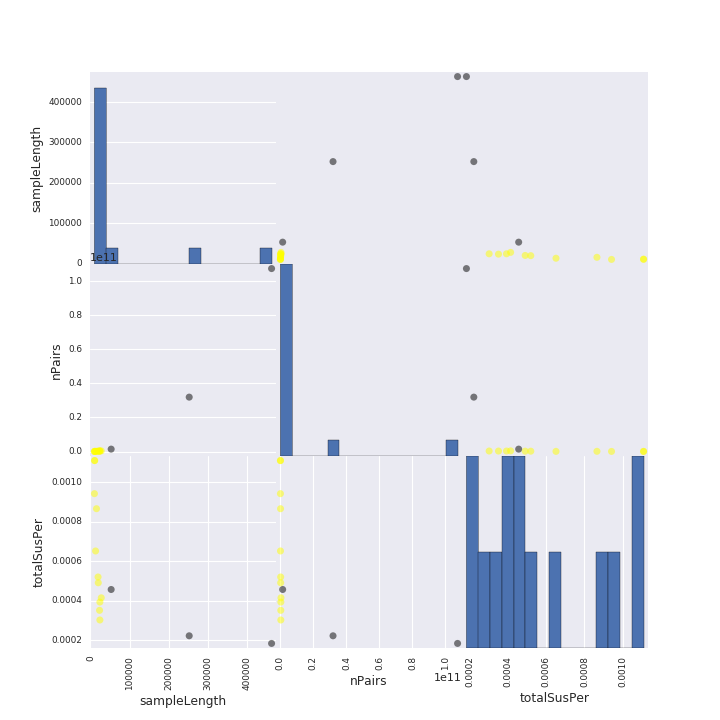

In [101]:
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(X, c= y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)


In [77]:
sample_name='HIP13853'
alt_dfs_folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seqRel/check_seqRel_%s/check_seqRel' %sample_name
Sample_seqRel=concat_summarizing_dfs(alt_dfs_folder)

number of dfs in directory: 464
the length of df list is 464


In [78]:
Sample_seqRel

,#mm,#seq1,#seq2,seq1,seq1 reads,seq2,seq2 reads
0,1,208036,432684,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,2
1,3,208040,208070,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11
2,3,208040,397191,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,3
3,3,208040,397229,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,3
4,1,208040,432694,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,2
5,1,208042,432605,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACCCAGCTGTGTACTTCTGTGCCAGCA...,2
6,3,208045,226728,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,10
7,3,208045,246576,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,9
8,3,208045,291465,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,7
9,3,208045,317561,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,11,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,6


In [46]:
calc_suspected_seqs_stats('BD64')

number of dfs in directory: 11
the length of df list is 11
sampleLength=10676
nPairs=56983150
percModSus=0.0
percHighSus=0
totalSusPer=0.00110909979529


In [66]:
calc_suspected_seqs_stats('BD64_281611_3')


number of dfs in directory: 16
the length of df list is 16
sampleLength=15435
nPairs=119111895
percModSus=0.0
percHighSus=0
totalSusPer=0.00086557266174


In [67]:
calc_suspected_seqs_stats('BD64_322939_1')


number of dfs in directory: 11
the length of df list is 11
sampleLength=10181
nPairs=51821290
percModSus=0.0
percHighSus=0
totalSusPer=0.000941697900612


In [68]:
calc_suspected_seqs_stats('BD64_322939_2')


number of dfs in directory: 11
the length of df list is 11
sampleLength=10676
nPairs=56983150
percModSus=0.0
percHighSus=0
totalSusPer=0.00110909979529
wtf


Exception in thread qp_dispatcher:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 709, in __dispatchqp
    rem_jobs, multip = self.__remainingjobs(multip)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line

wtf


Exception in thread qp_dispatcher:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 709, in __dispatchqp
    rem_jobs, multip = self.__remainingjobs(multip)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line

wtf


Exception in thread qp_dispatcher:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 709, in __dispatchqp
    rem_jobs, multip = self.__remainingjobs(multip)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line

wtf


Exception in thread qp_dispatcher:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 709, in __dispatchqp
    rem_jobs, multip = self.__remainingjobs(multip)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line

wtf


Exception in thread qp_dispatcher:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 709, in __dispatchqp
    rem_jobs, multip = self.__remainingjobs(multip)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line

wtf


Exception in thread qp_dispatcher:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 709, in __dispatchqp
    rem_jobs, multip = self.__remainingjobs(multip)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line 639, in __remainingjobs
    return self.__remainingjobs(multip, failed_i+1)
  File "/home/sbenari/workspace/lib/queue/qp.py", line

In [62]:
sample_name='BD64_322939_2'
sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name)
sampleLength=len(sample_df)
sampleLength

10676

In [30]:
sample_name='BD64_322939_2'
sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name)
if 'count (templates)' in sample_df.columns.values:
    column='count (templates)'
else:
    column='count (templates/reads)'


True

## some old graphical analysis:

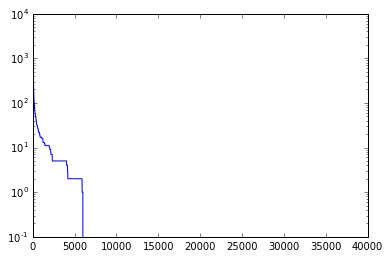

In [62]:
n_err_list=[]
seq1_reads_range=range(0,max(seqRelAllDF['seq1 reads']),10)
for n in seq1_reads_range:
    n_err=len(seqRelAllDF[(seqRelAllDF['seq1 reads']>=n)&(seqRelAllDF['seq2 reads']<3)])
    n_err_list.append(n_err)

plt.plot(seq1_reads_range,n_err_list)
#plt.xlable('number of reads - seq1')
#plt.ylable('number of potential erroneus sequences in seq2')
plt.yscale('log')
plt.xlim(-0.2,40000)
plt.ylim(0.1,10000)
#plt.margins(0.2)
plt.show()

In [33]:
seqRelAllDF['seq1 reads'].describe()

count    58852.000000
mean        60.392816
std        521.851105
min          2.000000
25%         18.000000
50%         30.000000
75%         48.000000
max      35398.000000
Name: seq1 reads, dtype: float64

In [34]:
seqRelAllDF['seq2 reads'].describe()

count    58852.000000
mean        14.251920
std         17.470641
min          2.000000
25%          4.000000
50%          9.000000
75%         20.000000
max       1484.000000
Name: seq2 reads, dtype: float64

In [37]:
print len(seqRelAllDF[seqRelAllDF['seq1 reads']<seqRelAllDF['seq2 reads']])

0


In [38]:
print len(seqRelAllDF[seqRelAllDF['seq1 reads']>seqRelAllDF['seq2 reads']])

57046


In [65]:
seqRelAllDF['#seq1'].describe()

count     58852.000000
mean      86294.825036
std       62928.481585
min           0.000000
25%       32010.000000
50%       75635.000000
75%      131497.000000
max      253260.000000
Name: #seq1, dtype: float64

In [66]:
seqRelAllDF['#seq2'].describe()

count     58852.000000
mean     170184.283236
std       66589.708747
min         115.000000
25%      120543.000000
50%      186142.000000
75%      228917.250000
max      253387.000000
Name: #seq2, dtype: float64

In [74]:
sigma(253387)

32102359191

In [75]:
print len(seqRelAllDF[(seqRelAllDF['seq1 reads']>=7000)&(seqRelAllDF['seq2 reads']<3)])

0


In [82]:
print len(seqRelAllDF[((seqRelAllDF['seq1 reads']>=10)&(seqRelAllDF['seq2 reads']<3)&(seqRelAllDF['#mm']==1))|
                     ((seqRelAllDF['seq1 reads']>=100)&(seqRelAllDF['seq2 reads']<3)&(seqRelAllDF['#mm']<4))])

4395


In [78]:
print len(seqRelAllDF[seqRelAllDF['#mm']==1])

13824


In [84]:
(13824.0/sigma(253387))*100

4.306225569825286e-05

In [93]:
(58852.0/sigma(253387))*100

0.00018332609030335487